<a href="https://colab.research.google.com/github/CarolBigData2016/google-colab/blob/master/dense_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding # new!
from keras.callbacks import ModelCheckpoint # new! 
import os # new! 
from sklearn.metrics import roc_auc_score, roc_curve # new!
import pandas as pd
import matplotlib.pyplot as plt # new!
%matplotlib inline

Using TensorFlow backend.


In [0]:
# output directory name:
output_dir = 'model_output/dense'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 # as per Maas et al. (2011); may not be optimal
n_words_to_skip = 50 # ditto
max_review_length = 100
pad_type = trunc_type = 'pre'

# neural network architecture: 
n_dense = 64
dropout = 0.5

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words, skip_top=n_words_to_skip) 

17465344/17464789 [==============================] - 0s 0us/step


In [4]:
x_train[0:6] # 0 reserved for padding; 1 would be starting character; 2 is unknown; 3 is most common word, etc.

array([list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]),
       list([2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 20

In [5]:
for x in x_train[0:6]:
    print(len(x))

218
189
141
550
147
43


In [6]:
y_train[0:6]

array([1, 0, 0, 1, 0, 0])

In [7]:
len(x_train), len(x_valid)

(25000, 25000)

In [8]:
word_index = keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2

1646592/1641221 [==============================] - 0s 0us/step


In [9]:
word_index

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [0]:
index_word = {v:k for k,v in word_index.items()}

In [12]:
x_train[0]

[2,
 2,
 2,
 2,
 2,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 2,
 256,
 2,
 2,
 100,
 2,
 838,
 112,
 50,
 670,
 2,
 2,
 2,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 2,
 336,
 385,
 2,
 2,
 172,
 4536,
 1111,
 2,
 546,
 2,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 2,
 530,
 2,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 2,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 2,
 2,
 480,
 66,
 3785,
 2,
 2,
 130,
 2,
 2,
 2,
 619,
 2,
 2,
 124,
 51,
 2,
 135,
 2,
 2,
 1415,
 2,
 2,
 2,
 2,
 215,
 2,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 2,
 2,
 2,
 107,
 117,
 2,
 2,
 256,
 2,
 2,
 2,
 3766,
 2,
 723,
 2,
 71,
 2,
 530,
 476,
 2,
 400,
 317,
 2,
 2,
 2,
 2,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 2,
 2071,
 56,
 2,
 141,
 2,
 194,
 2,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 2,
 480,
 2,
 144,
 2,
 2,
 2,
 51,
 2,
 2,
 224,
 92,
 2,
 104,
 2,
 226,
 65,
 2,
 2,
 1334,
 88,
 2

In [13]:
' '.join(index_word[id] for id in x_train[0])

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

In [0]:
(all_x_train,_),(all_x_valid,_) = imdb.load_data() 

In [15]:
' '.join(index_word[id] for id in all_x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

In [0]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [17]:
x_train[0:6]

array([[1415,    2,    2,    2,    2,  215,    2,   77,   52,    2,    2,
         407,    2,   82,    2,    2,    2,  107,  117,    2,    2,  256,
           2,    2,    2, 3766,    2,  723,    2,   71,    2,  530,  476,
           2,  400,  317,    2,    2,    2,    2, 1029,    2,  104,   88,
           2,  381,    2,  297,   98,    2, 2071,   56,    2,  141,    2,
         194,    2,    2,    2,  226,    2,    2,  134,  476,    2,  480,
           2,  144,    2,    2,    2,   51,    2,    2,  224,   92,    2,
         104,    2,  226,   65,    2,    2, 1334,   88,    2,    2,  283,
           2,    2, 4472,  113,  103,    2,    2,    2,    2,    2,  178,
           2],
       [ 163,    2, 3215,    2,    2, 1153,    2,  194,  775,    2,    2,
           2,  349, 2637,  148,  605,    2,    2,    2,  123,  125,   68,
           2,    2,    2,  349,  165, 4362,   98,    2,    2,  228,    2,
           2,    2, 1157,    2,  299,  120,    2,  120,  174,    2,  220,
         175,  136,   5

In [19]:
for x in x_train[0:6]:
    print(len(x))

100
100
100
100
100
100


In [20]:
' '.join(index_word[id] for id in x_train[0])

"cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK UNK UNK us UNK"

In [21]:
' '.join(index_word[id] for id in x_train[5])

'PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD UNK begins better than UNK ends funny UNK UNK russian UNK crew UNK UNK other actors UNK UNK those scenes where documentary shots UNK UNK spoiler part UNK message UNK UNK contrary UNK UNK whole story UNK UNK does UNK UNK UNK UNK'

In [22]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
# model.add(Dense(n_dense, activation='relu'))
# model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid')) # mathematically equivalent to softmax with two classes





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
model.summary() # so many parameters!

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


In [24]:
# embedding layer dimensions and parameters: 
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [25]:
# ...flatten:
max_review_length, n_dim, n_dim*max_review_length

(100, 64, 6400)

In [26]:
# ...dense:
n_dense, n_dim*max_review_length*n_dense + n_dense # weights + biases

(64, 409664)

In [27]:
# ...and output:
n_dense + 1 

65

**Configure Model**

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [0]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

**Train**

In [34]:
# 84.7% validation accuracy in epoch 2
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])




Train on 25000 samples, validate on 25000 samples
Epoch 1/4





25000/25000 [==============================] - 6s 227us/step - loss: 0.5439 - acc: 0.6998 - val_loss: 0.3476 - val_acc: 0.8471
Epoch 2/4
25000/25000 [==============================] - 5s 186us/step - loss: 0.2686 - acc: 0.8950 - val_loss: 0.3519 - val_acc: 0.8455
Epoch 3/4
25000/25000 [==============================] - 5s 200us/step - loss: 0.0989 - acc: 0.9711 - val_loss: 0.4372 - val_acc: 0.8345
Epoch 4/4
25000/25000 [==============================] - 5s 187us/step - loss: 0.0200 - acc: 0.9971 - val_loss: 0.5403 - val_acc: 0.8321


**Evaluate**

In [0]:
model.load_weights(output_dir+"/weights.01.hdf5") # zero-indexed

In [0]:
y_hat = model.predict_proba(x_valid)

In [38]:
len(y_hat)

25000

In [39]:
y_hat[0]

array([0.27685136], dtype=float32)

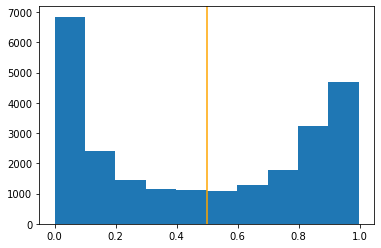

In [40]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [0]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [42]:
"{:0.2f}".format(pct_auc)

'92.80'

In [0]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [0]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [45]:
ydf.head(10)

,y_hat,y
0,0.276851,0
1,0.893580,1
2,0.445205,1
3,0.477739,0
4,0.972309,1
5,0.660683,1
6,0.686443,1
7,0.018161,0
8,0.639299,0
9,0.699583,1


In [46]:
' '.join(index_word[id] for id in all_x_valid[0])

"START please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss"

In [47]:
' '.join(index_word[id] for id in all_x_valid[6]) 

"START originally supposed to be just a part of a huge epic the year 1905 depicting the revolution of 1905 potemkin is the story of the mutiny of the crew of the potemkin in odessa harbor the film opens with the crew protesting meat and the captain ordering the execution of the an uprising takes place during which the revolutionary leader is killed this crewman is taken to the shore to lie in state when the townspeople gather on a huge flight of steps overlooking the harbor czarist troops appear and march down the steps breaking up the crowd a naval squadron is sent to retake the potemkin but at the moment when the ships come into range their crews allow the to pass through eisenstein's non historically accurate ending is open ended thus indicating that this was the seed of the later bolshevik revolution that would bloom in russia the film is broken into five parts men and maggots drama on the an appeal from the dead the odessa steps and meeting the squadron br br eisenstein was a revo

In [48]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10)

,y_hat,y
386,0.903433,0
778,0.918099,0
810,0.901922,0
1059,0.960606,0
1207,0.973318,0
2151,0.938903,0
2216,0.953732,0
2397,0.972621,0
2504,0.918892,0
2871,0.927615,0


In [49]:
' '.join(index_word[id] for id in all_x_valid[489]) 

"START apparently the film has a harsh anti bush message if it does i didn't get it that's all it is it's boring and useless period br br it's too serious at times to be a comedy too slow to be a thriller not funny not gripping not exciting not film it's too everything to be the opposite and vise versa i was amazed at how bad a film could suck don't even think of watching it br br i have watched literally hundreds of films and never have i been so obliged to write a warning on imdb avoid at all costs you have been warned br br even the making of is painfully boring it's just people talking gibberish with loads of inside jokes infront of a camera sort of like a home movie there even is a part where a guy takes you on a tour of the food that was consumed on the set by the film crew still beats the movie i guess"

In [50]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10)

,y_hat,y
159,0.069363,1
300,0.035081,1
325,0.080975,1
333,0.085505,1
581,0.096726,1
667,0.034110,1
973,0.053982,1
1122,0.040339,1
1192,0.053427,1
1229,0.055460,1


In [51]:
' '.join(index_word[id] for id in all_x_valid[927]) 

"START well i don't know much about anything but i sure liked this film in short it was creative humorous simple and heartwarming in other words it was everything it set out to be br br the story is set around a girl's first love as the title suggests and i certainly should warn you expect nothing challenging or provocative in terms of the subject matter here i mean it is a children's cartoon it's really just a simple story but it's told well and it holds your attention well br br in the end it's short it's funny it's cute it's simple it's good"